# Forecasting with ReservoirPy

## Data and hyperparameters

In [16]:
from reservoirpy.datasets import lorenz, rossler
from rcpy.data.data_generation import ulam_map
from rcpy.data import preprocess_data_rcpy 
import json

# ================================
# 1. DATA
# ================================

# ----- Generate or load raw data -----

#data_raw = ulam_map(x0=0.1, n_steps=10000, discard=1000)
#data_raw = lorenz(10000)
data_raw = rossler(11000)[1000:,0]


# ----- Preprocess data -----

offset = 0
train_length = 6000
val_length = 1000
warmup_length = 1000

data = preprocess_data_rcpy(
    data=data_raw,
    init_discard=offset,
    train_length=train_length,
    val_length=val_length,
    normalize=True
)
warmup_data=data['train_data'][-warmup_length:]

# ================================
# 2. HYPERPARAMETERS
# ================================

# ----- Load  -----
""" filename = f"../hypopt/best_hyperparams.json"
with open(filename, "r") as file:
    params = json.load(file)

reservoir_units = params['reservoir_units']
seed = params['seed']
leak_rate = params['leak_rate']
spectral_radius = params['spectral_radius']
input_scaling = params['input_scaling']
alpha = params['alpha']
p = params['p'] """

# ----- Manual input -----
#seed = np.random.randint(0, 10000)  # Random seed for reproducibility
seed = 9610
reservoir_units = 1000
spectral_radius = 1.1827917982886946
leak_rate = 1
input_scaling = 0.9599880559120382
alpha = 0.0018126936294128814
p = 0.1

## Forecasting

### Single forecasts

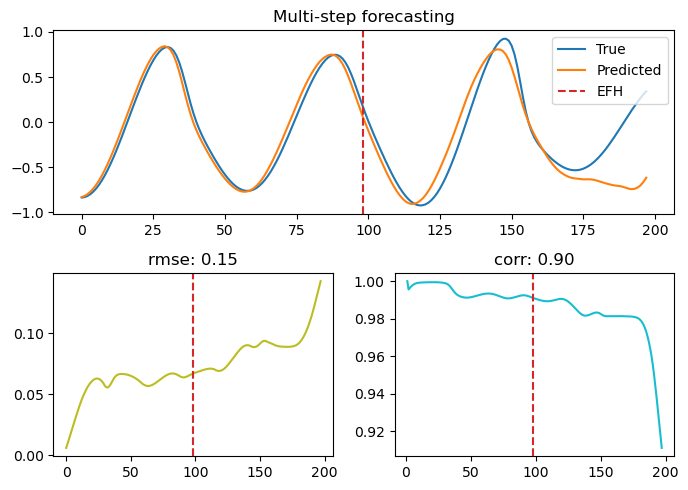

In [17]:
from rcpy.models import create_model
from rcpy.training import train_model
from rcpy.forecasting import forecast_rcpy
from rcpy.analysis import compute_skill
import matplotlib.pyplot as plt
from rcpy.plotting import plot_forecast

hyperparams = {
    'reservoir_units': reservoir_units,
    'leak_rate': leak_rate,
    'spectral_radius': spectral_radius,
    'input_scaling': input_scaling,
    'alpha': alpha,
    'p': p,
    'seed': seed
}


# ================================
# 3a. RESERVOIR
# ================================

# ----- Create model -----
model = create_model(hyperparams=hyperparams, output_dim=data['train_data'].shape[1])

# ----- Train model -----
washout_training = 1000
trained_model = train_model(model=model, data=data, forecasting_step=1, washout_training=washout_training)


# ================================
# 4a. FORECASTING
# ================================
warmup_length = 1000
forecast_length = 1000

Y_pred = forecast_rcpy(model=trained_model,
                        warmup_data=warmup_data,
                        forecast_length=forecast_length)
Y_true = data["val_data"][:forecast_length]

# ================================
# 5a. PERFORMANCE
# ================================

# ----- Compute skill ----- 
efh_threshold = 0.2
efh_softness = 0.02
efh = compute_skill(y_true=Y_true, y_pred=Y_pred, method='efh', threshold=efh_threshold, softness=efh_softness)
rmse_cumulative = compute_skill(y_true=Y_true, y_pred=Y_pred, method='error', mode="cumulative")
corr_cumulative = compute_skill(y_true=Y_true, y_pred=Y_pred, method='pearson', mode="cumulative")

# ----- Plot forecast -----
plot_cutoff = None
fig = plot_forecast(Y_pred=Y_pred, Y_true=Y_true, efh=efh, rmse_cumulative=rmse_cumulative, corr_cumulative=corr_cumulative, plot_cutoff=plot_cutoff)

### Ensemble forecasting

#### Global hyperparameters

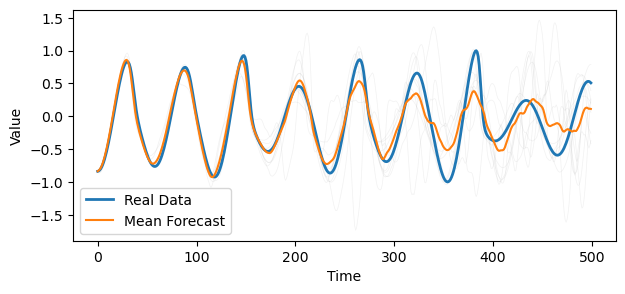

In [18]:
import numpy as np
from rcpy.forecasting import multiple_forecasts_rcpy
from rcpy.plotting import plot_multiforecasts

hyperparams = {
    'reservoir_units': reservoir_units,
    'leak_rate': leak_rate,
    'spectral_radius': spectral_radius,
    'input_scaling': input_scaling,
    'alpha': alpha,
    'p': p,
    'seed': seed
}

# ================================
# 3b. RESERVOIR & FORECASTING
# ================================

# ----- Parameters -----
discard_training = 1000 # Training
forecast_length = 500 # Forecasting
warmup_length = 1000

# Multiple forecasts
num_reservoirs = 10

# ----- Ensemble forecasting -----
Y_preds, seeds = multiple_forecasts_rcpy(
    data=data,
    warmup_data=warmup_data,
    hyperparams=hyperparams,
    seeds= None,
    discard_training= discard_training,
    forecast_length = forecast_length,
    num_reservoirs = num_reservoirs,
)

# ----- Saving predictions -----
#np.save('ensemble_forecast.npy', Y_preds)

# ================================
# 4b. PERFORMANCE
# ================================
fig = plot_multiforecasts(true_data=data["val_data"], forecasts=Y_preds, forecast_length=forecast_length)